In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from kdg.utils import plot_2dsim, gaussian_sparse_parity, generate_gaussian_parity
from tqdm import tqdm

In [2]:
def generate_task_data(sample_size, angle, latent_dim, noise_dim):
    X, y = generate_gaussian_parity(sample_size, angle_params=angle)
    X_noise = np.random.uniform(
                low=-1, high=1, size=(sample_size, noise_dim)
            )
    X = np.concatenate((X, X_noise), axis=1)
        
    
    X , y = torch.from_numpy(X.astype('float32')), torch.from_numpy(y.astype('float32'))

    return X, y

In [3]:
class TaskDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.clone()
        self.y = y.clone()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [83]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim, nodes=1000):
        super(Encoder, self).__init__()
        self.layer1 = nn.Linear(input_size, nodes)
        self.bn1 = nn.BatchNorm1d(nodes)
        self.layer2 = nn.Linear(nodes, nodes)
        self.bn2 = nn.BatchNorm1d(nodes)
        self.layer3 = nn.Linear(nodes, nodes)
        self.bn3 = nn.BatchNorm1d(nodes)
        self.layer4 = nn.Linear(nodes, nodes)
        self.bn4 = nn.BatchNorm1d(nodes)
        self.output = nn.Linear(nodes, latent_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.bn1(x))
        x = self.layer2(x)
        x = F.relu(self.bn2(x))
        x = self.layer3(x)
        x = F.relu(self.bn3(x))
        x = self.layer4(x)
        x = F.relu(self.bn4(x))
        x = self.output(x)

        return x
        

In [84]:
class Head(nn.Module):
    def __init__(self, latent_dim, output):
        super(Head, self).__init__()
        self.layer1 = nn.Linear(latent_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, output)
        

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)

        return x

In [85]:
class ContrastLoss(nn.Module):
    def __init__(self, latent_dim, margin=0.3, replay_const=1e-1):
        super(ContrastLoss, self).__init__()
        self.margin = margin
        self.replay_const = replay_const
        #self.head_to_consider = head_to_consider

    def forward(self, inputs, targets, inputs_replay, targets_replay):
        dis_embedding = torch.cdist(
                            inputs,
                            inputs,
                            p=2.0
                        )

        #idx = torch.randperm(targets.shape[1])[:self.head_to_consider]
        #print(idx)
        #targets = targets[:,:self.head_to_consider]
        number_of_heads = targets.shape[1]
        kernel_partition = torch.sum(
                            targets.view(1,-1,number_of_heads)==targets.view(-1,1,number_of_heads),
                            dim=2)/number_of_heads
        
        #print(kernel_partition, dis_embedding)
        dis_partition = (1-kernel_partition)>1e-12

        ############################################################
        dis_embedding_replay = torch.cdist(
                            inputs_replay,
                            inputs_replay,
                            p=2.0
                        )
        number_of_heads_replay = targets_replay.shape[1]
        kernel_partition_replay = torch.sum(
                            targets_replay.view(1,-1,number_of_heads_replay)==targets_replay.view(-1,1,number_of_heads_replay),
                            dim=2)/number_of_heads_replay
        
        #print(kernel_partition, dis_embedding)
        dis_partition_replay = (1-kernel_partition_replay)>1e-12

        
        #print(dis_partition)
        loss = torch.mul(
                        kernel_partition,
                        dis_embedding
                    ) + torch.clamp(torch.mul(
                        dis_partition,
                        self.margin-dis_embedding
                        ), 0.0)
        
        loss_replay = torch.mul(
                        kernel_partition_replay,
                        dis_embedding_replay
                    ) + torch.clamp(torch.mul(
                        dis_partition_replay,
                        self.margin-dis_embedding_replay
                        ), 0.0)
                
        return loss.mean() + self.replay_const*loss_replay.mean()

In [86]:
class ClassificationLoss(nn.Module):
    def __init__(self):
        super(ClassificationLoss, self).__init__()

    def forward(self, inputs, targets):
        print(inputs.size(), targets.size())
        loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        return loss.mean()

In [103]:
total_task = 20
task_data = {}
heads = {}
classes_per_task = 2
sample_per_task = 100
noise_dim = 8
latent_dim = 2
epoch_per_task_encoder = 200
epoch_per_task_head = 50
total_task_seen = 0
learning_rate_encoder = 3e-3
learning_rate_head = 3e-3
batch_size = 64
margin = 5.2
replay_const = 5e-2
X_replay = []
y_replay = []
###########################
task_angles = np.linspace(0,np.pi/4, total_task)
#np.random.shuffle(task_angles)

###########################
encoder = Encoder(input_size=noise_dim+latent_dim, latent_dim=latent_dim)
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate_encoder, momentum=0.9)
criterion_encoder = ContrastLoss(latent_dim, margin=margin, replay_const=replay_const)

for ii, angle in enumerate(task_angles):
    print('Doing Task ', ii+1)
    
    X, y = generate_task_data(sample_per_task, angle, latent_dim, noise_dim)
    y = y.view(-1,1)

    if ii == 0:
        X_replay = X
    else:
        X_replay = torch.cat((X_replay, X))
    
    with torch.no_grad():
        embedding = encoder(X)
        
        for jj in range(total_task_seen):
            head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
            y = torch.cat((y, head_predicted_label),
                        dim=1)

    
    #######################
    if ii == 0:
        y_replay = y
    else:
        with torch.no_grad():
            embedding = encoder(X_replay)
            
            for jj in range(total_task_seen):
                head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
    
                if jj == 0:
                    y_replay = head_predicted_label
                else:
                    y_replay = torch.cat((y_replay, head_predicted_label),
                                dim=1)

 
    
    train_loader = DataLoader(TaskDataset(X, y), batch_size=batch_size,
                                          shuffle=True)   
    replay_loader = DataLoader(TaskDataset(X_replay, y_replay), batch_size=batch_size,
                                          shuffle=True) 
    
    #task_data[ii] = train_loader
    ## train encoder ##
    for epoch in range(epoch_per_task_encoder):
        running_loss = 0.0

        count = 0
        for (X_, y_), (X_r, y_r) in zip(train_loader, replay_loader):
            encoder_optimizer.zero_grad()
            embedding = encoder(X_)
            embedding_replay = encoder(X_r)
            
            loss = criterion_encoder(embedding, y_, embedding_replay, y_r)
            #print(X_r.shape)
            loss.backward()
            encoder_optimizer.step()

            running_loss += loss.item()
            count += 1

    print("Epoch :", epoch+1, "loss :", running_loss/(count+1))
            

    ## train head ##
    heads[ii] = Head(latent_dim=latent_dim, output=classes_per_task)
    head_optimizer = torch.optim.SGD(heads[ii].parameters(), lr=learning_rate_head, momentum=0.9)
    criterion_head = nn.CrossEntropyLoss()
        
    for epoch in range(epoch_per_task_head):
        for X_, y_ in train_loader:
            head_optimizer.zero_grad()
            
            with torch.no_grad():
                embedding = encoder(X_)

            predicted_y = heads[ii](embedding)
            loss_head = criterion_head(predicted_y, y_[:,0].long())
            loss_head.backward()
            head_optimizer.step()
            
    print(f'head {ii+1} Epoch : {epoch+1}, loss: {loss_head:.4f}')

    total_task_seen += 1

Doing Task  1
Epoch : 200 loss : 0.0745235060652097
head 1 Epoch : 50, loss: 0.0106
Doing Task  2
Epoch : 200 loss : 0.5526520212491354
head 2 Epoch : 50, loss: 0.0068
Doing Task  3
Epoch : 200 loss : 0.43291326363881427
head 3 Epoch : 50, loss: 0.1223
Doing Task  4
Epoch : 200 loss : 0.5389246741930643
head 4 Epoch : 50, loss: 0.0251
Doing Task  5
Epoch : 200 loss : 0.39383338888486225
head 5 Epoch : 50, loss: 0.0777
Doing Task  6
Epoch : 200 loss : 0.7424228191375732
head 6 Epoch : 50, loss: 0.0882
Doing Task  7
Epoch : 200 loss : 0.6493305563926697
head 7 Epoch : 50, loss: 0.0089
Doing Task  8
Epoch : 200 loss : 0.7630693912506104
head 8 Epoch : 50, loss: 0.0727
Doing Task  9
Epoch : 200 loss : 0.4447985688845317
head 9 Epoch : 50, loss: 0.1032
Doing Task  10
Epoch : 200 loss : 0.867727796236674
head 10 Epoch : 50, loss: 0.2603
Doing Task  11
Epoch : 200 loss : 0.8478482564290365
head 11 Epoch : 50, loss: 0.2779
Doing Task  12
Epoch : 200 loss : 0.8885468244552612
head 12 Epoch : 50

In [105]:
for ii in range(total_task):
    X , y = generate_task_data(10000, task_angles[ii], latent_dim, noise_dim)
    embedding = encoder(X)
    head_predicted_label = heads[ii](embedding).argmax(1).view(-1,1)

    print(f'Task {ii+1} accuracy: ', torch.sum(y.view(-1,1)==head_predicted_label)/10000)    

Task 1 accuracy:  tensor(0.7940)
Task 2 accuracy:  tensor(0.8252)
Task 3 accuracy:  tensor(0.8397)
Task 4 accuracy:  tensor(0.8508)
Task 5 accuracy:  tensor(0.8669)
Task 6 accuracy:  tensor(0.8742)
Task 7 accuracy:  tensor(0.8811)
Task 8 accuracy:  tensor(0.9020)
Task 9 accuracy:  tensor(0.9055)
Task 10 accuracy:  tensor(0.9038)
Task 11 accuracy:  tensor(0.9088)
Task 12 accuracy:  tensor(0.9102)
Task 13 accuracy:  tensor(0.9135)
Task 14 accuracy:  tensor(0.9104)
Task 15 accuracy:  tensor(0.9071)
Task 16 accuracy:  tensor(0.9109)
Task 17 accuracy:  tensor(0.8931)
Task 18 accuracy:  tensor(0.8812)
Task 19 accuracy:  tensor(0.8779)
Task 20 accuracy:  tensor(0.8603)


In [112]:
task = 0
X , y = generate_task_data(1000, task_angles[task], latent_dim, noise_dim)

In [113]:
embedding = encoder(X)
head_predicted_label = heads[task](embedding).argmax(1).view(-1,1)

In [114]:
criterion_encoder = ContrastLoss(latent_dim)
#criterion_encoder(embedding, y, 3)

<AxesSubplot: >

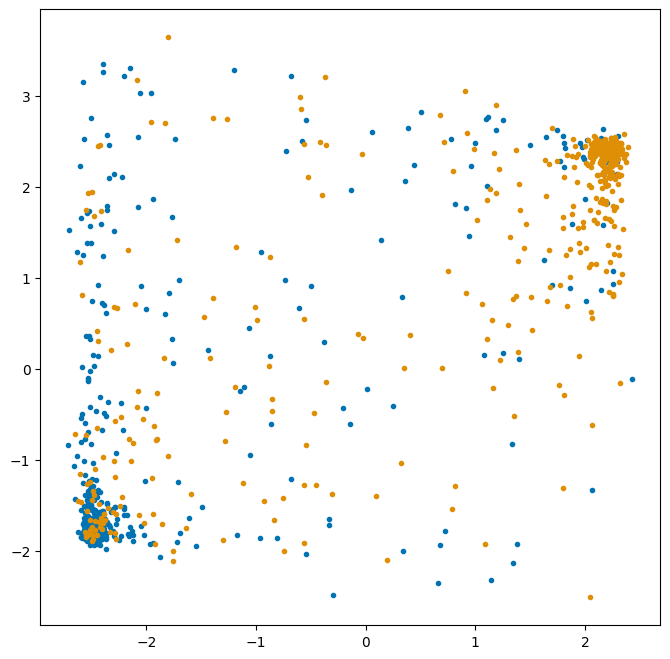

In [115]:
plot_2dsim(embedding.detach().numpy(), y.view(-1).numpy().astype('int'))
#plot_2dsim(embedding.detach().numpy(), y[:,0].view(-1).numpy().astype('int'))

<AxesSubplot: >

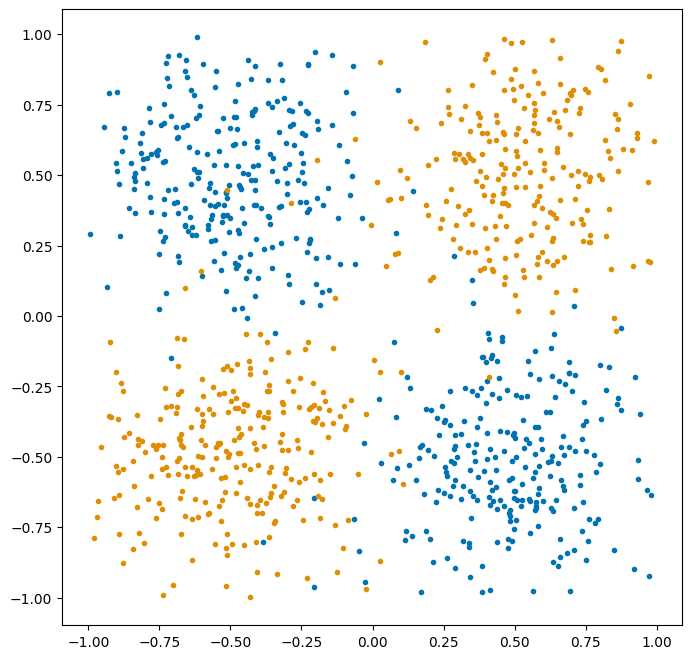

In [116]:
plot_2dsim(X.detach().numpy()[:,:2], y.view(-1).numpy().astype('int'))

In [117]:
torch.sum(y.view(-1,1)==head_predicted_label)/1000

tensor(0.7830)